# Working with Order Book Data: NASDAQ ITCH

The primary source of market data is the order book, which is continuously updated in real-time throughout the day to reflect all trading activity. Exchanges typically offer this data as a real-time service and may provide some historical data for free.

The trading activity is reflected in numerous messages about trade orders sent by market participants. These messages typically conform to the electronic Financial Information eXchange (FIX) communications protocol for real-time exchange of securities transactions and market data or a native exchange protocol. 

## Imports

In [1]:
from pathlib import Path
from collections import Counter
from datetime import timedelta
from datetime import datetime
from time import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [3]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

### Set Data paths

We will store the download in a `data` subdirectory and convert the result to `hdf` format (discussed in the last section of chapter 2).

In [4]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'
date = '10302019'

## Build Order Book

In [5]:
stock = 'AAPL'
order_dict = {-1: 'sell', 1: 'buy'}

The parsed messages allow us to rebuild the order flow for the given day. The 'R' message type contains a listing of all stocks traded during a given day, including information about initial public offerings (IPOs) and trading restrictions.

Throughout the day, new orders are added, and orders that are executed and canceled are removed from the order book. The proper accounting for messages that reference orders placed on a prior date would require tracking the order book over multiple days, but we are ignoring this aspect here.

### Get all messages for given stock

The `get_messages()` function illustrates how to collect the orders for a single stock that affects trading (refer to the ITCH specification for details about each message):

In [6]:
def get_messages(date, stock=stock):
    """Collect trading messages for given stock"""
    with pd.HDFStore(itch_store) as store:
        stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
        target = 'stock_locate = stock_locate'

        data = {}
        # trading message types
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
        for m in messages:
            data[m] = store.select(m, where=target).drop('stock_locate', axis=1).assign(type=m)

    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

    for m in messages[2: -3]:
        data[m] = data[m].merge(orders, how='left')

    data['U'] = data['U'].merge(orders, how='left',
                                right_on='order_reference_number',
                                left_on='original_order_reference_number',
                                suffixes=['', '_replaced'])

    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    data['X']['shares'] = data['X']['cancelled_shares']
    data['X'] = data['X'].dropna(subset=['price'])

    data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
    data['date'] = pd.to_datetime(date, format='%m%d%Y')
    data.timestamp = data['date'].add(data.timestamp)
    data = data[data.printable != 0]

    drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
                 'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
                 'printable', 'date', 'cancelled_shares']
    return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)


In [7]:
messages = get_messages(date=date)
messages.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813995 entries, 0 to 813994
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           813995 non-null  datetime64[ns]
 1   buy_sell_indicator  755909 non-null  float64       
 2   shares              808719 non-null  float64       
 3   price               808719 non-null  float64       
 4   type                813995 non-null  object        
 5   executed_shares     54582 non-null   float64       
 6   execution_price     371 non-null     float64       
 7   shares_replaced     4886 non-null    float64       
 8   price_replaced      4886 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 55.9+ MB


In [8]:
with pd.HDFStore(order_book_store) as store:
    key = f'{stock}/messages'
    store.put(key, messages)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/messages            frame        (shape->[813995,9])


### Combine Trading Records

Reconstructing successful trades, that is, orders that are executed as opposed to those that were canceled from trade-related message types, C, E, P, and Q, is relatively straightforward:

In [9]:
def get_trades(m):
    """Combine C, E, P and Q messages into trading records"""
    trade_dict = {'executed_shares': 'shares', 'execution_price': 'price'}
    cols = ['timestamp', 'executed_shares']
    trades = pd.concat([m.loc[m.type == 'E', cols + ['price']].rename(columns=trade_dict),
                        m.loc[m.type == 'C', cols + ['execution_price']].rename(columns=trade_dict),
                        m.loc[m.type == 'P', ['timestamp', 'price', 'shares']],
                        m.loc[m.type == 'Q', ['timestamp', 'price', 'shares']].assign(cross=1),
                        ], sort=False).dropna(subset=['price']).fillna(0)
    return trades.set_index('timestamp').sort_index().astype(int)

In [10]:
trades = get_trades(messages)
print(trades.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72015 entries, 2019-10-30 04:00:02.486519868 to 2019-10-30 19:59:59.248635671
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   shares  72015 non-null  int64
 1   price   72015 non-null  int64
 2   cross   72015 non-null  int64
dtypes: int64(3)
memory usage: 2.2 MB
None


In [11]:
with pd.HDFStore(order_book_store) as store:
    store.put(f'{stock}/trades', trades)

### Create Orders

The order book keeps track of limit orders, and the various price levels for buy and sell orders constitute the depth of the order book. To reconstruct the order book for a given level of depth requires the following steps:


The `add_orders()` function accumulates sell orders in ascending, and buy orders in descending order for a given timestamp up to the desired level of depth:

In [12]:
def add_orders(orders, buysell, nlevels):
    """Add orders up to desired depth given by nlevels;
        sell in ascending, buy in descending order
    """
    new_order = []
    items = sorted(orders.copy().items())
    if buysell == 1:
        items = reversed(items)  
    for i, (p, s) in enumerate(items, 1):
        new_order.append((p, s))
        if i == nlevels:
            break
    return orders, new_order

In [13]:
def save_orders(orders, append=False):
    cols = ['price', 'shares']
    for buysell, book in orders.items():
        df = (pd.concat([pd.DataFrame(data=data,
                                     columns=cols)
                         .assign(timestamp=t) 
                         for t, data in book.items()]))
        key = f'{stock}/{order_dict[buysell]}'
        df.loc[:, ['price', 'shares']] = df.loc[:, ['price', 'shares']].astype(int)
        with pd.HDFStore(order_book_store) as store:
            if append:
                store.append(key, df.set_index('timestamp'), format='t')
            else:
                store.put(key, df.set_index('timestamp'))

We iterate over all ITCH messages and process orders and their replacements as required by the specification (this can take a while):

In [14]:
order_book = {-1: {}, 1: {}}
current_orders = {-1: Counter(), 1: Counter()}
message_counter = Counter()
nlevels = 100

start = time()
for message in messages.itertuples():
    i = message[0]
    if i % 1e5 == 0 and i > 0:
        print(f'{i:,.0f}\t\t{format_time(time() - start)}')
        save_orders(order_book, append=True)
        order_book = {-1: {}, 1: {}}
        start = time()
    if np.isnan(message.buy_sell_indicator):
        continue
    message_counter.update(message.type)

    buysell = message.buy_sell_indicator
    price, shares = None, None

    if message.type in ['A', 'F', 'U']:
        price = int(message.price)
        shares = int(message.shares)

        current_orders[buysell].update({price: shares})
        current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
        order_book[buysell][message.timestamp] = new_order

    if message.type in ['E', 'C', 'X', 'D', 'U']:
        if message.type == 'U':
            if not np.isnan(message.shares_replaced):
                price = int(message.price_replaced)
                shares = -int(message.shares_replaced)
        else:
            if not np.isnan(message.price):
                price = int(message.price)
                shares = -int(message.shares)

        if price is not None:
            current_orders[buysell].update({price: shares})
            if current_orders[buysell][price] <= 0:
                current_orders[buysell].pop(price)
            current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
            order_book[buysell][message.timestamp] = new_order

100,000		00:00:35
200,000		00:00:48
300,000		00:00:50
400,000		00:00:51
500,000		00:00:53
600,000		00:00:53
700,000		00:00:55
800,000		00:00:46


In [15]:
message_counter = pd.Series(message_counter)
print(message_counter)

A    357225
E     52781
D    318295
P     18861
X       576
F      2928
U      4886
C       357
dtype: int64


In [16]:
with pd.HDFStore(order_book_store) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/buy                 frame_table  (typ->appendable,nrows->37503256,ncols->2,indexers->[index],dc->[])
/AAPL/messages            frame        (shape->[813995,9])                                                
/AAPL/sell                frame_table  (typ->appendable,nrows->30746169,ncols->2,indexers->[index],dc->[])
/AAPL/trades              frame        (shape->[72015,3])                                                 


## Order Book Depth

In [17]:
with pd.HDFStore(order_book_store) as store:
    buy = store[f'{stock}/buy'].reset_index().drop_duplicates()
    sell = store[f'{stock}/sell'].reset_index().drop_duplicates()

### Price to Decimals

In [18]:
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

### Remove outliers

In [19]:
percentiles = [.01, .02, .1, .25, .75, .9, .98, .99]
pd.concat([buy.price.describe(percentiles=percentiles).to_frame('buy'),
           sell.price.describe(percentiles=percentiles).to_frame('sell')], axis=1)

,buy,sell
count,3.750326e+07,3.074617e+07
mean,2.436934e+02,2.496396e+02
std,2.001204e+00,1.137489e+03
min,1.000000e-02,2.412500e+02
1%,2.425800e+02,2.414600e+02
2%,2.427700e+02,2.416300e+02
10%,2.430600e+02,2.421100e+02
25%,2.432700e+02,2.425500e+02
50%,2.436000e+02,2.430200e+02
75%,2.440700e+02,2.435900e+02


In [20]:
buy = buy[buy.price > buy.price.quantile(.01)]
sell = sell[sell.price < sell.price.quantile(.99)]

### Buy-Sell Order Distribution

The number of orders at different price levels, highlighted in the following screenshot using different intensities for buy and sell orders, visualizes the depth of liquidity at any given point in time.

The distribution of limit order prices was weighted toward buy orders at higher prices.

In [21]:
market_open='0930'
market_close = '1600'

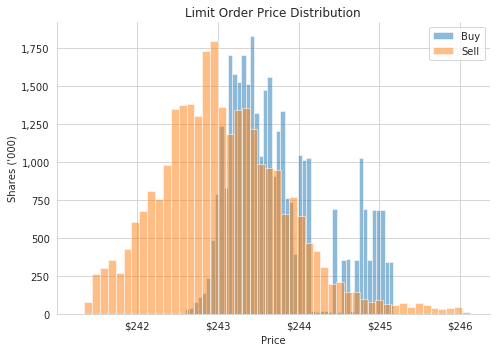

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
hist_kws = {'linewidth': 1, 'alpha': .5}
sns.distplot(buy[buy.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price, 
             ax=ax, label='Buy', kde=False, hist_kws=hist_kws)
sns.distplot(sell[sell.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price, 
             ax=ax, label='Sell', kde=False, hist_kws=hist_kws)

ax.legend(fontsize=10)
ax.set_title('Limit Order Price Distribution')
ax.set_yticklabels([f'{int(y/1000):,}' for y in ax.get_yticks().tolist()])
ax.set_xticklabels([f'${int(x):,}' for x in ax.get_xticks().tolist()])
ax.set_xlabel('Price')
ax.set_ylabel('Shares (\'000)')
sns.despine()
fig.tight_layout();

### Order Book Depth

In [23]:
utc_offset = timedelta(hours=4)
depth = 100

In [24]:
buy_per_min = (buy
               .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
               .shares
               .sum()
               .apply(np.log)
               .to_frame('shares')
               .reset_index('price')
               .between_time(market_open, market_close)
               .groupby(level='timestamp', as_index=False, group_keys=False)
               .apply(lambda x: x.nlargest(columns='price', n=depth))
               .reset_index())
buy_per_min.timestamp = buy_per_min.timestamp.add(utc_offset).astype(int)
buy_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39100 entries, 0 to 39099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  39100 non-null  int64  
 1   price      39100 non-null  float64
 2   shares     39100 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 916.5 KB


In [25]:
sell_per_min = (sell
                .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
                .shares
                .sum()
                .apply(np.log)
                .to_frame('shares')
                .reset_index('price')
                .between_time(market_open, market_close)
                .groupby(level='timestamp', as_index=False, group_keys=False)
                .apply(lambda x: x.nsmallest(columns='price', n=depth))
                .reset_index())

sell_per_min.timestamp = sell_per_min.timestamp.add(utc_offset).astype(int)
sell_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39100 entries, 0 to 39099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  39100 non-null  int64  
 1   price      39100 non-null  float64
 2   shares     39100 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 916.5 KB


In [26]:
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0].between_time(market_open, market_close)

trades_per_min = (trades
                  .resample('Min')
                  .agg({'price': 'mean', 'shares': 'sum'}))
trades_per_min.index = trades_per_min.index.to_series().add(utc_offset).astype(int)
trades_per_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 1572442200000000000 to 1572465540000000000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   390 non-null    float64
 1   shares  390 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 9.1 KB


The following plots the evolution of limit orders and prices throughout the trading day: the dark line tracks the prices for executed trades during market hours, whereas the red and blue dots indicate individual limit orders on a per-minute basis (see notebook for details)

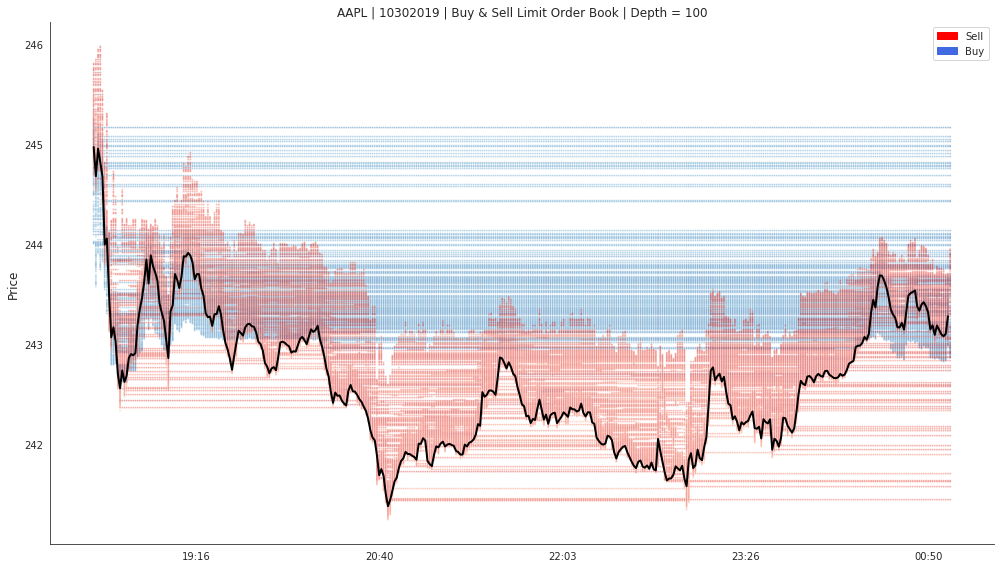

In [28]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14, 6))

buy_per_min.plot.scatter(x='timestamp',
                         s=1,
                         y='price', 
                         c='shares', 
                         ax=ax, 
                         colormap='Blues', 
                         colorbar=False, 
                         alpha=.25)

sell_per_min.plot.scatter(x='timestamp',
                          s=1,
                          y='price', 
                          c='shares', 
                          ax=ax, 
                          colormap='Reds', 
                          colorbar=False, 
                          alpha=.25)

title = f'AAPL | {date} | Buy & Sell Limit Order Book | Depth = {depth}'
trades_per_min.price.plot(figsize=(14, 8), 
                          c='k', 
                          ax=ax, 
                          lw=2, 
                          title=title)

xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

ax.set_xlabel('')
ax.set_ylabel('Price', fontsize=12)

red_patch = mpatches.Patch(color='red', label='Sell')
blue_patch = mpatches.Patch(color='royalblue', label='Buy')

plt.legend(handles=[red_patch, blue_patch])
sns.despine()
fig.tight_layout()